In [1]:
%matplotlib inline


# MaD DiGait Pipeline

This pipeline showcases the current gait analysis pipeline used by the MaD-Lab with all required steps:
Preprocessing -> Stride Segmentation -> Event Detection -> Trajectory Reconstruction -> Parameter Estimation

This should serve as a compact example that can be copied and pasted into new projects.
For more details on the individual steps have a look at the extended examples and the documentation of the main classes:

- `Preprocessing <example_preprocessing>`
- `Stride Segmentation (BarthDTW) <example_barth_stride_segmentation>`
- `Event Detection (RamppEventDetection) <example_rampp_event_detection>`
- `Trajectory Reconstruction (double Integration) <example_preprocessing>`
- `Temporal Parameters <example_temporal_parameters>` and `Spatial Parameters <example_spatial_parameters>`


In [2]:
pip install gaitmap

Note: you may need to restart the kernel to use updated packages.


## Load example data



In [2]:
import numpy as np
import pandas as pd 

np.random.seed(0)

example_dataset = pd.read_csv('17may.csv', index_col=False)
sampling_rate_hz = 50

from gaitmap.preprocessing import sensor_alignment

In [3]:
type(example_dataset)

pandas.core.frame.DataFrame

In [4]:
example_dataset.head(1)

,Time,Device name设备名称,Acceleration X(g),Acceleration Y(g),Acceleration Z(g),Angular velocity X(°/s),Angular velocity Y(°/s),Angular velocity Z(°/s),Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,12:32:51.144,WT901BLE68(d8:09:5a:ca:b6:e0),0.974,0.103,0.263,0.549,-0.244,-0.183,21.374,-73.872,176.891,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824


In [5]:
renamed = {'Device name设备名称':'Device name','Acceleration X(g)':'acc_x','Acceleration Y(g)':'acc_y','Acceleration Z(g)':'acc_z',
'Angular velocity X(°/s)':'gyr_x','Angular velocity Y(°/s)':'gyr_y','Angular velocity Z(°/s)':'gyr_z'}

example_dataset = example_dataset.rename(columns=renamed)
example_dataset.head()

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,12:32:51.144,WT901BLE68(d8:09:5a:ca:b6:e0),0.974,0.103,0.263,0.549,-0.244,-0.183,21.374,-73.872,176.891,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824
1,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.100,0.263,0.183,0.000,0.183,21.368,-73.872,176.847,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824
2,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.974,0.101,0.263,0.549,-0.305,0.305,21.352,-73.872,176.808,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824
3,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.100,0.263,0.183,0.000,0.183,21.368,-73.872,176.847,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824
4,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.101,0.263,0.549,-0.305,0.305,21.352,-73.872,176.808,-16.562,-89.18,16.464,33.47,-0.09711,0.59232,0.13531,0.78824


In [6]:
example_dataset.drop(['Angle X(°)','Angle Y(°)','Angle Z(°)','Magnetic field X(ʯt)','Magnetic field Y(ʯt)','Magnetic field Z(ʯt)','Temperature(℃)','Quaternions 0()','Quaternions 1()','Quaternions 2()','Quaternions 3()'],axis=1,inplace=True)
example_dataset

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
0,12:32:51.144,WT901BLE68(d8:09:5a:ca:b6:e0),0.974,0.103,0.263,0.549,-0.244,-0.183
1,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.100,0.263,0.183,0.000,0.183
2,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.974,0.101,0.263,0.549,-0.305,0.305
3,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.100,0.263,0.183,0.000,0.183
4,12:32:51.146,WT901BLE68(d8:09:5a:ca:b6:e0),0.972,0.101,0.263,0.549,-0.305,0.305
...,...,...,...,...,...,...,...,...
2067,12:33:05.448,WT901BLE68(cc:c4:7a:a1:fe:ea),0.727,-0.306,-0.268,22.400,10.376,136.536
2068,12:33:05.500,WT901BLE68(cc:c4:7a:a1:fe:ea),0.768,-0.367,-0.195,19.287,-18.555,144.592
2069,12:33:05.500,WT901BLE68(cc:c4:7a:a1:fe:ea),0.861,-0.413,-0.140,32.959,-49.744,156.067
2070,12:33:05.526,WT901BLE68(cc:c4:7a:a1:fe:ea),1.095,-0.373,-0.140,54.077,-95.032,152.222


In [7]:
example_dataset.columns

Index(['Time', 'Device name', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y',
       'gyr_z'],
      dtype='object')

In [8]:
# Function to convert DataFrame to dictionary of DataFrames
def df_to_dict_of_dfs(df):
    device_names = df['Device name'].unique()
    dfs_dict = {}

    for device_name in device_names:
        device_df = df[df['Device name'] == device_name].copy()
        device_df.drop(columns='Device name', inplace=True)
        dfs_dict[device_name] = device_df.reset_index(drop=True)
    
    return dfs_dict

# Convert DataFrame to dictionary of DataFrames
dfs_dict = df_to_dict_of_dfs(example_dataset)
dfs_dict

{'WT901BLE68(d8:09:5a:ca:b6:e0)':                Time  acc_x  acc_y  acc_z    gyr_x    gyr_y    gyr_z
 0      12:32:51.144  0.974  0.103  0.263    0.549   -0.244   -0.183
 1      12:32:51.146  0.972  0.100  0.263    0.183    0.000    0.183
 2      12:32:51.146  0.974  0.101  0.263    0.549   -0.305    0.305
 3      12:32:51.146  0.972  0.100  0.263    0.183    0.000    0.183
 4      12:32:51.146  0.972  0.101  0.263    0.549   -0.305    0.305
 ...             ...    ...    ...    ...      ...      ...      ...
 1431   12:33:05.051  1.871 -0.520  0.540  152.771  -99.915 -152.588
 1432   12:33:05.051  1.794 -0.900  0.775  142.212  -97.351 -124.390
 1433   12:33:05.051  1.635 -1.156  0.824  123.779 -112.732  -97.717
 1434   12:33:05.051  1.794 -1.120  0.911  107.178 -118.774  -55.054
 1435   12:33:05.051  1.635 -1.156  0.824  123.779 -112.732  -97.717
 
 [1436 rows x 7 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':               Time  acc_x  acc_y  acc_z   gyr_x    gyr_y    gyr_z
 0     12:3

In [9]:

# Print the dictionary of DataFrames
for device_name, device_df in dfs_dict.items():
    print(f"Device Name: {device_name}")
    print(device_df)
    print()

Device Name: WT901BLE68(d8:09:5a:ca:b6:e0)
               Time  acc_x  acc_y  acc_z    gyr_x    gyr_y    gyr_z
0      12:32:51.144  0.974  0.103  0.263    0.549   -0.244   -0.183
1      12:32:51.146  0.972  0.100  0.263    0.183    0.000    0.183
2      12:32:51.146  0.974  0.101  0.263    0.549   -0.305    0.305
3      12:32:51.146  0.972  0.100  0.263    0.183    0.000    0.183
4      12:32:51.146  0.972  0.101  0.263    0.549   -0.305    0.305
...             ...    ...    ...    ...      ...      ...      ...
1431   12:33:05.051  1.871 -0.520  0.540  152.771  -99.915 -152.588
1432   12:33:05.051  1.794 -0.900  0.775  142.212  -97.351 -124.390
1433   12:33:05.051  1.635 -1.156  0.824  123.779 -112.732  -97.717
1434   12:33:05.051  1.794 -1.120  0.911  107.178 -118.774  -55.054
1435   12:33:05.051  1.635 -1.156  0.824  123.779 -112.732  -97.717

[1436 rows x 7 columns]

Device Name: WT901BLE68(cc:c4:7a:a1:fe:ea)
              Time  acc_x  acc_y  acc_z   gyr_x    gyr_y    gyr_z
0     

In [10]:
from gaitmap.utils.datatype_helper import get_multi_sensor_names
get_multi_sensor_names(dfs_dict)

dict_keys(['WT901BLE68(d8:09:5a:ca:b6:e0)', 'WT901BLE68(cc:c4:7a:a1:fe:ea)'])

In [11]:
from gaitmap.utils.datatype_helper import is_sensor_data

is_sensor_data(dfs_dict, frame="sensor")


'multi'

In [12]:
is_sensor_data(dfs_dict['WT901BLE68(d8:09:5a:ca:b6:e0)'], frame="sensor")

'single'

## Preprocessing
Fix the alignment between the sensor coordinate system and the gaitmap coordinate system.
This will be different for each sensor position and recording.



In [13]:
from scipy.spatial.transform import Rotation

# For multiple sensors, we write down the rotation matrices for each sensor into a dict
rotation_matrices = {
      'WT901BLE68(d8:09:5a:ca:b6:e0)': Rotation.from_matrix(np.array([[ 0, 1,  0], [ 0,  0,  1], [1,  0,  0]])),
      'WT901BLE68(cc:c4:7a:a1:fe:ea)': Rotation.from_matrix(np.array([[ 0,  -1,  0], [ 0,  0, -1], [1,  0,  0]]))
}
from gaitmap.utils.rotations import rotate_dataset

# We assume `data` has two sensors with the same names as in the dict above
data = rotate_dataset(dfs_dict, rotation_matrices)
data

{'WT901BLE68(d8:09:5a:ca:b6:e0)':                Time  acc_x  acc_y  acc_z    gyr_x    gyr_y    gyr_z
 0      12:32:51.144  0.103  0.263  0.974   -0.244   -0.183    0.549
 1      12:32:51.146  0.100  0.263  0.972    0.000    0.183    0.183
 2      12:32:51.146  0.101  0.263  0.974   -0.305    0.305    0.549
 3      12:32:51.146  0.100  0.263  0.972    0.000    0.183    0.183
 4      12:32:51.146  0.101  0.263  0.972   -0.305    0.305    0.549
 ...             ...    ...    ...    ...      ...      ...      ...
 1431   12:33:05.051 -0.520  0.540  1.871  -99.915 -152.588  152.771
 1432   12:33:05.051 -0.900  0.775  1.794  -97.351 -124.390  142.212
 1433   12:33:05.051 -1.156  0.824  1.635 -112.732  -97.717  123.779
 1434   12:33:05.051 -1.120  0.911  1.794 -118.774  -55.054  107.178
 1435   12:33:05.051 -1.156  0.824  1.635 -112.732  -97.717  123.779
 
 [1436 rows x 7 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':               Time  acc_x  acc_y  acc_z    gyr_x    gyr_y   gyr_z
 0     12:3

## Stride Segmentation
In this step the continuous datastream is segmented into individual strides.
For longer datasets it might be required to first identify segments of walking to reduce the chance of
false-positives.



In [14]:
from gaitmap.stride_segmentation import BarthDtw
from gaitmap.utils.coordinate_conversion import convert_to_fbf

dtw = BarthDtw()
# Convert data to foot-frame
bf_data = convert_to_fbf(data, left_like="WT901BLE68(d8:09:5a:ca:b6:e0)", right_like="WT901BLE68(cc:c4:7a:a1:fe:ea)")
dtw = dtw.segment(data=bf_data, sampling_rate_hz=sampling_rate_hz)

In [15]:
segmented_strides = dtw.stride_list_
segmented_strides

{'WT901BLE68(d8:09:5a:ca:b6:e0)':       start   end
 s_id             
 0        29    63
 1        69   102
 2       108   170
 3       170   222
 4       285   397
 5       397   510
 6       510   622
 7       622   734
 8       734   845
 9       845   958
 10      958  1070
 11     1070  1177
 12     1177  1282
 13     1282  1329
 14     1394  1434,
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':       start  end
 s_id            
 0        26   88
 1        88  145
 2       145  200
 3       200  240
 4       240  276
 5       303  343
 6       401  457
 7       457  508
 8       508  562
 9       562  621}

In [16]:
dtw_warping_path = dtw.paths_
dtw_warping_path

{'WT901BLE68(d8:09:5a:ca:b6:e0)': [array([[ 0, 31],
         [ 1, 32],
         [ 2, 33],
         [ 3, 34],
         [ 4, 35],
         [ 5, 36],
         [ 6, 37],
         [ 7, 37],
         [ 8, 37],
         [ 9, 37],
         [10, 37],
         [11, 37],
         [12, 37],
         [13, 37],
         [14, 37],
         [15, 38],
         [16, 39],
         [17, 40],
         [18, 41],
         [19, 41],
         [20, 41],
         [21, 41],
         [22, 41],
         [23, 42],
         [24, 43],
         [25, 44],
         [26, 45],
         [27, 46],
         [28, 47],
         [29, 48],
         [29, 49],
         [29, 50],
         [29, 51],
         [29, 52],
         [29, 53],
         [29, 54],
         [29, 55],
         [29, 56],
         [29, 57],
         [29, 58],
         [29, 59],
         [30, 60],
         [31, 61],
         [32, 62],
         [33, 63],
         [34, 64],
         [35, 65],
         [36, 66],
         [37, 67],
         [38, 68],
         [39, 69]

In [17]:
bf_data

{'WT901BLE68(d8:09:5a:ca:b6:e0)':       acc_pa  acc_ml  acc_si   gyr_pa   gyr_ml   gyr_si
 0      0.103   0.263  -0.974    0.244    0.183   -0.549
 1      0.100   0.263  -0.972   -0.000   -0.183   -0.183
 2      0.101   0.263  -0.974    0.305   -0.305   -0.549
 3      0.100   0.263  -0.972   -0.000   -0.183   -0.183
 4      0.101   0.263  -0.972    0.305   -0.305   -0.549
 ...      ...     ...     ...      ...      ...      ...
 1431  -0.520   0.540  -1.871   99.915  152.588 -152.771
 1432  -0.900   0.775  -1.794   97.351  124.390 -142.212
 1433  -1.156   0.824  -1.635  112.732   97.717 -123.779
 1434  -1.120   0.911  -1.794  118.774   55.054 -107.178
 1435  -1.156   0.824  -1.635  112.732   97.717 -123.779
 
 [1436 rows x 6 columns],
 'WT901BLE68(cc:c4:7a:a1:fe:ea)':      acc_pa  acc_ml  acc_si   gyr_pa   gyr_ml  gyr_si
 0     0.439   0.075  -0.896   -0.732   -0.000   0.732
 1     0.439   0.074  -0.896   -0.977   -0.122   1.038
 2     0.438   0.076  -0.898   -1.038    0.061   1.160
 3

In [18]:
dtw

BarthDtw(conflict_resolution=True, find_matches_method='find_peaks', max_cost=4.0, max_match_length_s=3.0, max_signal_stretch_ms=None, max_template_stretch_ms=None, memory=None, min_match_length_s=0.6, resample_template=True, snap_to_min_axis='gyr_ml', snap_to_min_win_ms=300, template=BarthOriginalTemplate(scaling=FixedScaler(offset=0, scale=500.0), use_cols=None))

## Event detection
For each identified stride, we now identify important stride events.



In [19]:
from gaitmap.event_detection import RamppEventDetection

ed = RamppEventDetection()
ed = ed.detect(data=bf_data, stride_list=dtw.stride_list_, sampling_rate_hz=sampling_rate_hz)

## Trajectory Reconstruction
Using the identified events the trajectory of each stride is reconstructed using double integration starting from the
`min_vel` event of each stride.



In [20]:
from gaitmap.trajectory_reconstruction import StrideLevelTrajectory

trajectory = StrideLevelTrajectory()
trajectory = trajectory.estimate(
    data=data, stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz
)

## Temporal Parameter Calculation
Now we have all information to calculate relevant temporal parameters (like stride time)



In [21]:
from gaitmap.parameters import TemporalParameterCalculation

temporal_paras = TemporalParameterCalculation()
temporal_paras = temporal_paras.calculate(stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz)

## Spatial Parameter Calculation
Like the temporal parameters, we can also calculate the spatial parameter.



In [22]:
from gaitmap.parameters import SpatialParameterCalculation

spatial_paras = SpatialParameterCalculation()
spatial_paras = spatial_paras.calculate(
    stride_event_list=ed.min_vel_event_list_,
    positions=trajectory.position_,
    orientations=trajectory.orientation_,
    sampling_rate_hz=sampling_rate_hz,
)

## Inspecting the Results
The class of each step allows you to inspect all results in detail.
Here we will just print and plot the most important once.
Note, that the plots below are for sure not the best way to represent results!



In [23]:
import matplotlib.pyplot as plt

print(
    f"The following number of strides were identified and parameterized for each sensor: {({k: len(v) for k, v in ed.min_vel_event_list_.items()})}"
)

The following number of strides were identified and parameterized for each sensor: {'WT901BLE68(d8:09:5a:ca:b6:e0)': 8, 'WT901BLE68(cc:c4:7a:a1:fe:ea)': 7}


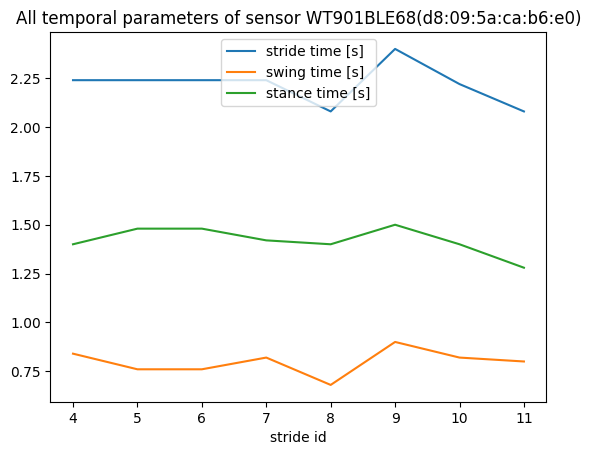

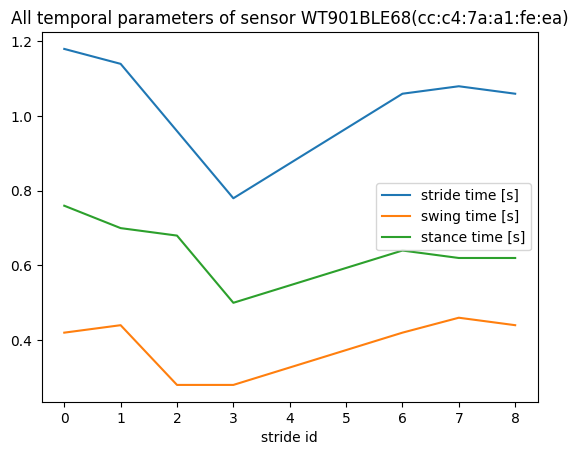

In [24]:
for k, v in temporal_paras.parameters_pretty_.items():
    v.plot()
    plt.title(f"All temporal parameters of sensor {k}")

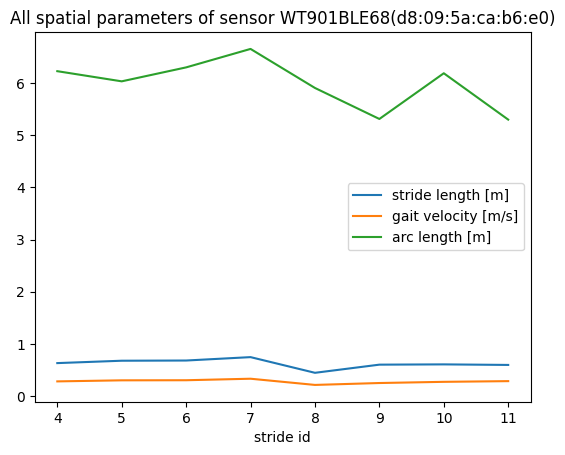

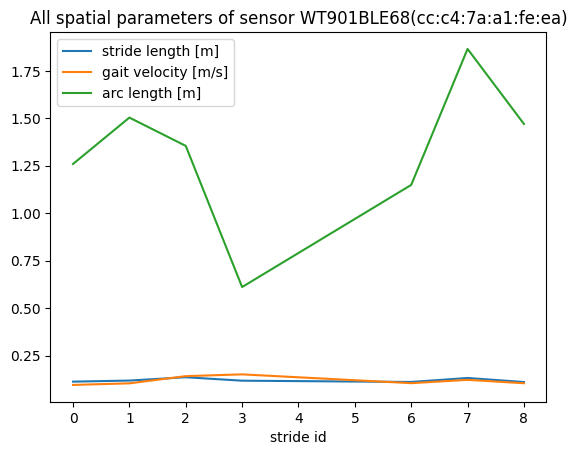

In [25]:
for k, v in spatial_paras.parameters_pretty_.items():
    v[["stride length [m]", "gait velocity [m/s]", "arc length [m]"]].plot()
    plt.title(f"All spatial parameters of sensor {k}")

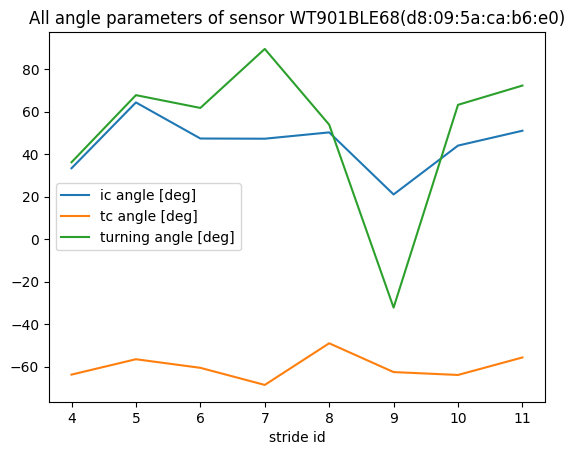

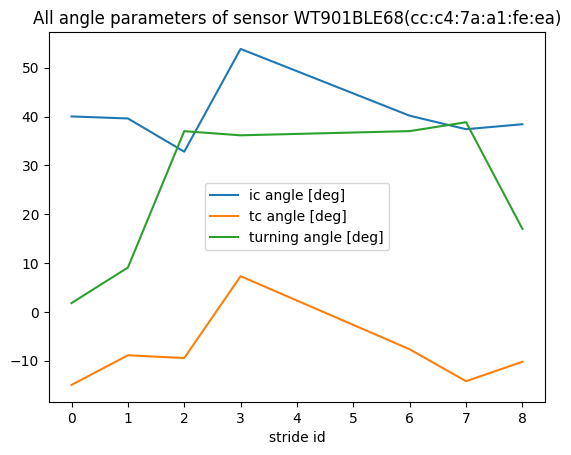

In [26]:
for k, v in spatial_paras.parameters_pretty_.items():
    v.filter(like="angle").plot()
    plt.title(f"All angle parameters of sensor {k}")

In [27]:
for k, v in spatial_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(d8:09:5a:ca:b6:e0)            arc length [m]  gait velocity [m/s]  ic angle [deg]  \
stride id                                                        
4                6.226683             0.282567       33.329874   
5                6.032181             0.302925       64.274687   
6                6.299419             0.304665       47.312325   
7                6.653279             0.333712       47.221179   
8                5.905198             0.214911       50.191420   
9                5.311203             0.251359       21.013918   
10               6.186974             0.274095       43.984883   
11               5.298685             0.287452       50.973466   

           max. lateral excursion [m]  max. orientation change [deg]  \
stride id                                                              
4                            0.026199                     108.377583   
5                            0.135625                     133.969732   
6                    

In [28]:
for k, v in temporal_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(d8:09:5a:ca:b6:e0)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
4                     2.24            0.84             1.40
5                     2.24            0.76             1.48
6                     2.24            0.76             1.48
7                     2.24            0.82             1.42
8                     2.08            0.68             1.40
9                     2.40            0.90             1.50
10                    2.22            0.82             1.40
11                    2.08            0.80             1.28
WT901BLE68(cc:c4:7a:a1:fe:ea)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
0                     1.18            0.42             0.76
1                     1.14            0.44             0.70
2                     0.96            0.28             0.68
3                     0.78            0.

In [48]:
x = temporal_paras.parameters_pretty_.values()

In [49]:
y = list(x)

In [50]:
temporal_left = y[0]
temporal_right = y[1]

In [54]:
temporal_left

,stride time [s],swing time [s],stance time [s]
stride id,,,
4,2.24,0.84,1.40
5,2.24,0.76,1.48
6,2.24,0.76,1.48
7,2.24,0.82,1.42
8,2.08,0.68,1.40
9,2.40,0.90,1.50
10,2.22,0.82,1.40
11,2.08,0.80,1.28


In [55]:
temporal_right

,stride time [s],swing time [s],stance time [s]
stride id,,,
0,1.18,0.42,0.76
1,1.14,0.44,0.70
2,0.96,0.28,0.68
3,0.78,0.28,0.50
6,1.06,0.42,0.64
7,1.08,0.46,0.62
8,1.06,0.44,0.62


In [56]:
temporal = pd.concat([temporal_left, temporal_right])

In [51]:
a = spatial_paras.parameters_pretty_.values()
b = list(a)
spatial_left = b[0]
spatial_right = b[1]

In [93]:
columns = ['Elapsed Time(s)', 'Left Stride Interval(s)', 'Right Stride Interval(s)', 
           'Left Swing Interval(s)', 'Right Swing Interval(s)', 
           'Left Swing Interval(%)', 'Right Swing Interval(%)', 
           'Left Stance Interval(s)', 'Right Stance Interval(s)', 
           'Left Stance Interval(%)', 'Right Stance Interval(%)', 
           'Double Support Interval(s)', 'Double Support Interval(%)']

# Create an empty DataFrame with the defined columns
result_df = pd.DataFrame(columns=columns)

In [96]:
result_df['Elapsed Time(s)'] = temporal['stride time [s]']

# Derive required features
result_df['Left Stride Interval(s)'] = temporal_left['stride time [s]']
result_df['Right Stride Interval(s)'] = temporal_right['stride time [s]']

d = result_df.min()
print(d)
result_df.iloc[:,:3] = result_df.iloc[:,:3].fillna(d)
result_df

Elapsed Time(s)               0.78
Left Stride Interval(s)       2.08
Right Stride Interval(s)      0.78
Left Swing Interval(s)        None
Right Swing Interval(s)       None
Left Swing Interval(%)        None
Right Swing Interval(%)       None
Left Stance Interval(s)       None
Right Stance Interval(s)      None
Left Stance Interval(%)       None
Right Stance Interval(%)      None
Double Support Interval(s)    None
Double Support Interval(%)    None
dtype: object


,Elapsed Time(s),Left Stride Interval(s),Right Stride Interval(s),Left Swing Interval(s),Right Swing Interval(s),Left Swing Interval(%),Right Swing Interval(%),Left Stance Interval(s),Right Stance Interval(s),Left Stance Interval(%),Right Stance Interval(%),Double Support Interval(s),Double Support Interval(%)
stride id,,,,,,,,,,,,,
4,2.24,2.24,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.24,2.24,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.24,2.24,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.24,2.24,1.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.08,2.08,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.40,2.40,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2.22,2.22,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.08,2.08,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1.18,2.08,1.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
another_df

,Left Swing Interval(s),Right Swing Interval(s),Left Swing Interval(%),Right Swing Interval(%),Left Stance Interval(s),Right Stance Interval(s),Left Stance Interval(%),Right Stance Interval(%),Double Support Interval(s),Double Support Interval(%)
stride id,,,,,,,,,,
4,0.84,NaN,NaN,NaN,1.40,NaN,NaN,NaN,NaN,NaN
5,0.76,NaN,NaN,NaN,1.48,NaN,NaN,NaN,NaN,NaN
6,0.76,0.42,NaN,NaN,1.48,0.64,NaN,NaN,NaN,NaN
7,0.82,0.46,NaN,NaN,1.42,0.62,NaN,NaN,NaN,NaN
8,0.68,0.44,NaN,NaN,1.40,0.62,NaN,NaN,NaN,NaN
9,0.90,NaN,NaN,NaN,1.50,NaN,NaN,NaN,NaN,NaN
10,0.82,NaN,NaN,NaN,1.40,NaN,NaN,NaN,NaN,NaN
11,0.80,NaN,NaN,NaN,1.28,NaN,NaN,NaN,NaN,NaN


In [97]:
# Fill 'result_df' with necessary values
result_df['Left Swing Interval(s)'] = temporal_left['swing time [s]']
result_df['Right Swing Interval(s)'] = temporal_right['swing time [s]']
result_df['Left Stance Interval(s)'] = temporal_left['stance time [s]']
result_df['Right Stance Interval(s)'] = temporal_right['stance time [s]']

# Calculate derived features in 'result_df'
result_df['Left Swing Interval(%)'] = (result_df['Left Swing Interval(s)'] / result_df['Left Stride Interval(s)']) * 100
result_df['Right Swing Interval(%)'] = (result_df['Right Swing Interval(s)'] / result_df['Right Stride Interval(s)']) * 100
result_df['Left Stance Interval(%)'] = (result_df['Left Stance Interval(s)'] / result_df['Left Stride Interval(s)']) * 100
result_df['Right Stance Interval(%)'] = (result_df['Right Stance Interval(s)'] / result_df['Right Stride Interval(s)']) * 100

result_df['Double Support Interval(s)'] = temporal['stride time [s]'] - (result_df['Left Swing Interval(s)'] + result_df['Right Swing Interval(s)']) / 2
result_df['Double Support Interval(%)'] = (result_df['Double Support Interval(s)'] / temporal['stride time [s]']) * 100

In [98]:
result_df

,Elapsed Time(s),Left Stride Interval(s),Right Stride Interval(s),Left Swing Interval(s),Right Swing Interval(s),Left Swing Interval(%),Right Swing Interval(%),Left Stance Interval(s),Right Stance Interval(s),Left Stance Interval(%),Right Stance Interval(%),Double Support Interval(s),Double Support Interval(%)
stride id,,,,,,,,,,,,,
4,2.24,2.24,0.78,0.84,NaN,37.500000,NaN,1.40,NaN,62.500000,NaN,NaN,NaN
5,2.24,2.24,0.78,0.76,NaN,33.928571,NaN,1.48,NaN,66.071429,NaN,NaN,NaN
6,2.24,2.24,1.06,0.76,0.42,33.928571,39.622642,1.48,0.64,66.071429,60.377358,1.65,73.660714
7,2.24,2.24,1.08,0.82,0.46,36.607143,42.592593,1.42,0.62,63.392857,57.407407,1.60,71.428571
8,2.08,2.08,1.06,0.68,0.44,32.692308,41.509434,1.40,0.62,67.307692,58.490566,1.52,73.076923
9,2.40,2.40,0.78,0.90,NaN,37.500000,NaN,1.50,NaN,62.500000,NaN,NaN,NaN
10,2.22,2.22,0.78,0.82,NaN,36.936937,NaN,1.40,NaN,63.063063,NaN,NaN,NaN
11,2.08,2.08,0.78,0.80,NaN,38.461538,NaN,1.28,NaN,61.538462,NaN,NaN,NaN
0,1.18,2.08,1.18,NaN,0.42,NaN,35.593220,NaN,0.76,NaN,64.406780,NaN,NaN


In [99]:
result_df.iloc[:,3:] = result_df.iloc[:,3:].fillna(result_df.iloc[:,3:].min())
result_df

,Elapsed Time(s),Left Stride Interval(s),Right Stride Interval(s),Left Swing Interval(s),Right Swing Interval(s),Left Swing Interval(%),Right Swing Interval(%),Left Stance Interval(s),Right Stance Interval(s),Left Stance Interval(%),Right Stance Interval(%),Double Support Interval(s),Double Support Interval(%)
stride id,,,,,,,,,,,,,
4,2.24,2.24,0.78,0.84,0.28,37.500000,29.166667,1.40,0.50,62.500000,57.407407,0.44,40.740741
5,2.24,2.24,0.78,0.76,0.28,33.928571,29.166667,1.48,0.50,66.071429,57.407407,0.44,40.740741
6,2.24,2.24,1.06,0.76,0.42,33.928571,39.622642,1.48,0.64,66.071429,60.377358,1.65,73.660714
7,2.24,2.24,1.08,0.82,0.46,36.607143,42.592593,1.42,0.62,63.392857,57.407407,1.60,71.428571
8,2.08,2.08,1.06,0.68,0.44,32.692308,41.509434,1.40,0.62,67.307692,58.490566,1.52,73.076923
9,2.40,2.40,0.78,0.90,0.28,37.500000,29.166667,1.50,0.50,62.500000,57.407407,0.44,40.740741
10,2.22,2.22,0.78,0.82,0.28,36.936937,29.166667,1.40,0.50,63.063063,57.407407,0.44,40.740741
11,2.08,2.08,0.78,0.80,0.28,38.461538,29.166667,1.28,0.50,61.538462,57.407407,0.44,40.740741
0,1.18,2.08,1.18,0.68,0.42,32.692308,35.593220,1.28,0.76,61.538462,64.406780,0.44,40.740741


In [102]:
result_df.reset_index(drop=True, inplace=True)
result_df

,Elapsed Time(s),Left Stride Interval(s),Right Stride Interval(s),Left Swing Interval(s),Right Swing Interval(s),Left Swing Interval(%),Right Swing Interval(%),Left Stance Interval(s),Right Stance Interval(s),Left Stance Interval(%),Right Stance Interval(%),Double Support Interval(s),Double Support Interval(%)
0,2.24,2.24,0.78,0.84,0.28,37.500000,29.166667,1.40,0.50,62.500000,57.407407,0.44,40.740741
1,2.24,2.24,0.78,0.76,0.28,33.928571,29.166667,1.48,0.50,66.071429,57.407407,0.44,40.740741
2,2.24,2.24,1.06,0.76,0.42,33.928571,39.622642,1.48,0.64,66.071429,60.377358,1.65,73.660714
3,2.24,2.24,1.08,0.82,0.46,36.607143,42.592593,1.42,0.62,63.392857,57.407407,1.60,71.428571
4,2.08,2.08,1.06,0.68,0.44,32.692308,41.509434,1.40,0.62,67.307692,58.490566,1.52,73.076923
5,2.40,2.40,0.78,0.90,0.28,37.500000,29.166667,1.50,0.50,62.500000,57.407407,0.44,40.740741
6,2.22,2.22,0.78,0.82,0.28,36.936937,29.166667,1.40,0.50,63.063063,57.407407,0.44,40.740741
7,2.08,2.08,0.78,0.80,0.28,38.461538,29.166667,1.28,0.50,61.538462,57.407407,0.44,40.740741
8,1.18,2.08,1.18,0.68,0.42,32.692308,35.593220,1.28,0.76,61.538462,64.406780,0.44,40.740741
9,1.14,2.08,1.14,0.68,0.44,32.692308,38.596491,1.28,0.70,61.538462,61.403509,0.44,40.740741


In [103]:
result_df.to_csv('readings1.csv')